# Techniques from "Exploring the Capability of Text-to-Image Diffusion Models With Structural Edge Guidance for Multispectral Satellite Image Inpainting"

## Prep
We are going to build on top of two external tools:
* `ControlNetInpaint` - a more general implementation of the conditionde inpainting mechanism developed for this work, the framework has been created by the same first author.

### Direct Access:
* https://github.com/mikonvergence/ControlNetInpaint

In [2]:
from src import *

Choose between `SMALL_TEMPORAL_GAP` example (about 2 weeks) and large gap (about 5 months)

/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'Tested Inpainting')

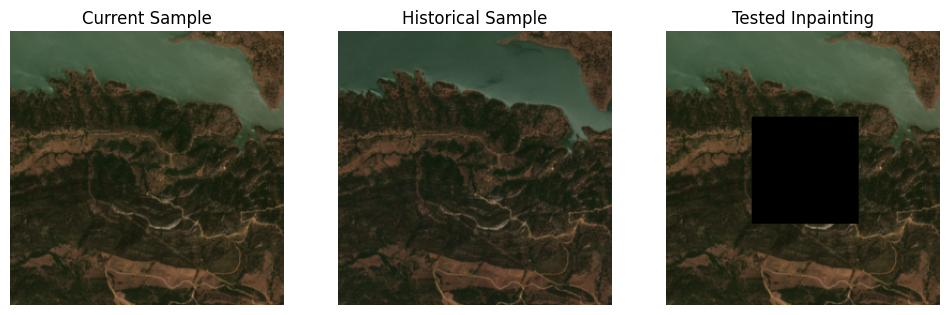

In [3]:
BIG_TEMPORAL_GAP=False
size=256

if not BIG_TEMPORAL_GAP:
    current_path = './example_data/small-gap/404U_51L_S2L2A/S2A_MSIL2A_20180805T110621_N0206_R137_T30STF_20180805T133536'
    hist_path = './example_data/small-gap/404U_51L_S2L2A/S2B_MSIL2A_20180721T110619_N0208_R137_T30STF_20180721T154606'
    
    current = read_s2(current_path)
    hist = read_s2(hist_path)
    mask = torch.ones(256,256)

else:
    bands = [i for i in range(1,14) if i != 11] # exclude cirrus band of L1C
    with rio.open('./example_data/big-gap/s2_ROIs1970_21_ImgNo_29_2018-12-22_patch_236.tif', 'r') as f:
        current = torch.from_numpy(f.read(bands)/4e3).float()
    
    with rio.open('./example_data/big-gap/s2_ROIs1970_21_ImgNo_17_2018-07-30_patch_236.tif', 'r') as f:
        hist = torch.from_numpy(f.read(bands)/4e3).float()

    mask = torch.ones(current.shape[-2:])

current = current[...,:size,:size]
hist = hist[...,:size,:size]
mask = mask[...,:size,:size]
mask[...,80:180,80:180] = 0

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plot_s2(current)
plt.title('Current Sample')
plt.subplot(1,3,2)
plot_s2(hist)
plt.title('Historical Sample')
plt.subplot(1,3,3)
plot_s2(current*mask)
plt.title('Tested Inpainting')

## Methods

* `EG` - Edge-Guided Diffusion variant from the manuscript
* `SD` - StableDiffusion Inpainting without additional control
* `DIP` - Direct use of Deep Image Prior

In [4]:
model = InpainterMSI(type='EG')

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


You can control the synthesis in several ways:
* `prompt` (for `'SD'` and `'EG'` modes) - text prompt to condition the RGB synthesis on
* `text_guidance_scale` (for `'SD'` and `'EG'` modes) - strength of alignment with text prompt
* `num_inference_steps` (for `'SD'` and `'EG'` modes) - number of diffusion steps for the RGB synthesis\
* `num_DIP_steps` - number of multi-spectral propagation steps with DIP

In [5]:
out = model(current,
            mask,
            condition=hist,
            #prompt='Your custom text prompt',
            text_guidance_scale = 7.5, # influence of text prompt
            edge_guidance_scale = 0.5, # influence of historical edge
            num_inference_steps=20, # number of diffusion RGB inpainting steps
            num_DIP_steps=4000 # number of DIP optimisation steps for RGB-to-MSI
           )

STEP I: RGB-based Inpainting


  0%|          | 0/20 [00:00<?, ?it/s]

/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


STEP II: MSI Expansion


You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mczerkawski/mambaforge/envs/miko-torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Text(0.5, 1.0, 'Original')

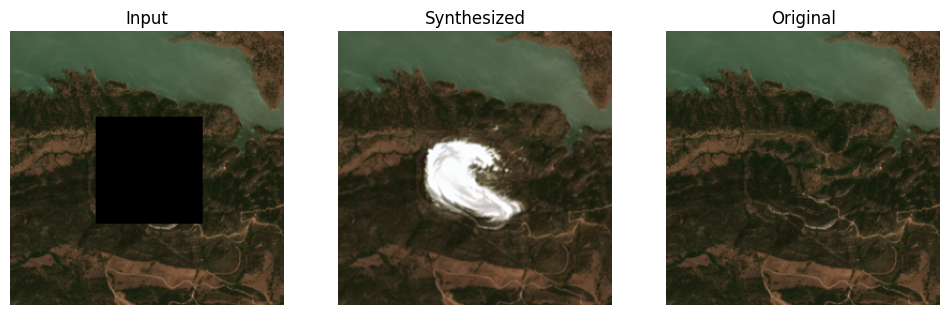

In [6]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plot_s2(current * mask)
plt.title('Input')
plt.subplot(1,3,2)
plot_s2(out)
plt.title('Synthesized')
plt.subplot(1,3,3)
plot_s2(current)
plt.title('Original')

> Note: sometimes, you might see the text-to-image diffusion model generate new objects inside the inpainted area, such as snowy mountain peaks. This kind of distortion is more thoroughly analysised in the published paper that this code is written for: https://github.com/strath-ai/multispectral-satellite-inpainting-with-text

You can also view all of the multi-spectral channels like here:

Text(0.5, 1.0, 'Original')

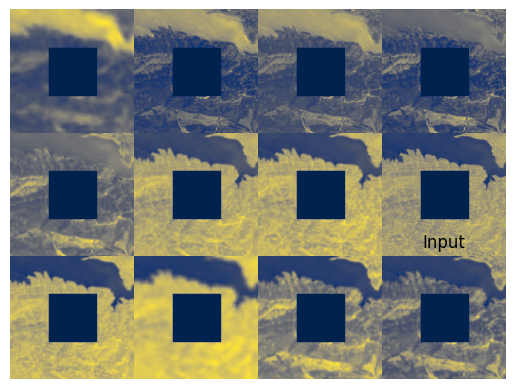

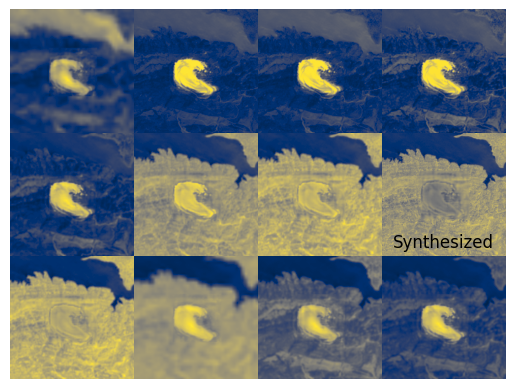

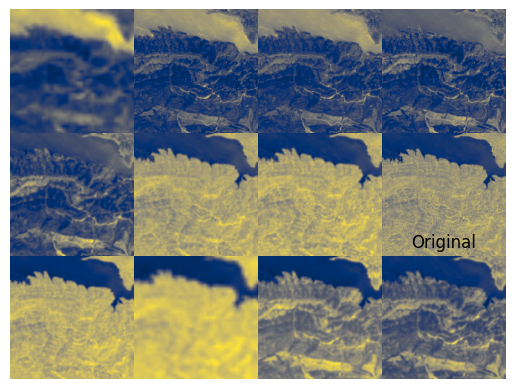

In [7]:
plt.figure()
plt.subplot(1,3,1)
plot_s2(current * mask, msi=True)
plt.title('Input')
plt.figure()
plot_s2(out, msi=True)
plt.title('Synthesized')
plt.figure()
plot_s2(current, msi=True)
plt.title('Original')